# Đồ án cuối kỳ NMKHDL 18-21
Thành viên nhóm:

- Vương Gia Bảo - MSSV: 18120009
    
- Du Chí Nhân - MSSV: 18120492

## Khai báo thư viện sử dụng trong đồ án

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

%matplotlib inline

## Thông tin về bộ dữ liệu

Dữ liệu được thu thập từ đường link: https://www.eia.gov/opendata/qb.php?category=241335&sdid=PET.RWTC.W


Đây là bộ dữ liệu về giá trị WTI được ghi nhận theo từng tuần bắt đầu từ ngày 03/01/1986 cho đến nay của Cơ quan quản lý thông tin năng lượng Mỹ. 


Về chỉ số WTI (West Texas Intermediate), là một loại dầu thô được sử dụng mức chuẩn trong giá dầu, đây là một loại hàng hóa cơ bản của các hợp đồng tương lai dầu của sàn giao dịch hàng hóa New York (Theo wikipedia).


Ở đây có hướng dẫn sử dụng API để thu thập dữ liệu. Để thu thập dữ liệu, ta cần phải đăng ký API key, sau đó sử dụng key vừa đăng ký để lấy dữ liệu, bằng cách nhập API key vào file `apikey.txt` tự tạo sau đó bỏ comment 2 cell code bên dưới và chạy thử, bên dưới là đoạn code dùng để thu thập dữ liệu:

In [2]:
# import requests
# import json
# with open('apikey.txt','r') as f:
#     api_key=f.read()
# url ='http://api.eia.gov/series/?api_key={}&series_id=PET.RWTC.W'.format(api_key)

# rq = requests.get(url)
# text = rq.text

# data=json.loads(text)

In [6]:
# df = pd.DataFrame(data['series'][0]['data'],columns=['period','value'])
# df.set_index('period', inplace=True)
# df.index = pd.to_datetime(df.index,format='%Y%m%d')
# df.sort_index(inplace=True)
# df.head()

Ngoài ra để thuận tiện hơn, dữ liệu thu thập được đã được chuyển sang dạng file csv ở file `data.csv` được đính kèm cùng với file notebook này.

## Khám phá dữ liệu (Để xác định câu hỏi)

In [3]:
df = pd.read_csv('data.csv',index_col='period')
df.index = pd.to_datetime(df.index)
df.head()

,value
period,
1986-01-03,25.78
1986-01-10,25.99
1986-01-17,24.57
1986-01-24,20.31
1986-01-31,19.69


### Dữ liệu có bao nhiêu dòng và cột?

In [4]:
df.shape

(1827, 1)

### Mỗi dòng của dữ liệu có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng dữ liệu là một bản ghi về giá trị WTI của 1 tuần nhất định và đơn vị được tính ở đây là Dollars per Barrel (Đô la/thùng).

In [5]:
df.dtypes

value    float64
dtype: object

In [6]:
df.isna().sum()

value    0
dtype: int64

Tất cả các dòng của cột value đều nhận kiểu giá trị `float64`, vậy không có dòng nào có ý nghĩa khác nhau.

Ngoài ra, dữ liệu không có dòng nào bị thiếu hay mất dữ liệu.

### Dữ liệu có các dòng bị trùng nhau không?

Do đây là dữ liệu về giá trị WTI nên việc giống nhau giữa các mốc thời gian là hoàn toàn có thể xảy ra, ta sẽ chỉ kiểm tra xem liệu có các ngày ghi nhận bị trùng nhau hay không.

In [7]:
df.index.duplicated().sum()

0

Vậy là không có các tuần ghi nhận bị trùng nhau trong tập dữ liệu.

## Đưa ra câu hỏi cần trả lời

Dữ liệu của chúng ta cũng không có quá nhiều thuộc tính để xem xét. Dựa vào ý nghĩa của dữ liệu, câu hỏi được đặt ra sẽ là: Giá trị WTI của tuần này tăng hay giảm so với hôm qua được tính như thế nào từ giá trị WTI của 3 tuần giao dịch trước đó.

Với những thông tin cần thiết để trả lời câu hỏi sẽ do ta tự xây dựng với ý tưởng như sau:

- Dùng phương thức `shift` của thư viện `pandas` để dịch giá trị của các tuần xuống `i` đơn vị và tạo thành một thuộc tính mới là giá trị của `i` tuần giao dịch trước đó.
    
- Trạng thái tăng hay giảm giá sẽ được lưu vào thuộc tính `state` được tính bằng cách so sánh giá được ghi nhận của 1 tuần và tuần trước đó.

- Loại bỏ cột `value` là giá trị WTI của tuần hiện tại.

Cài đặt cụ thể sẽ như hàm `build_table` bên dưới với 2 tham số:

- df: Dữ liệu về giá trị WTI được ghi nhận theo tuần.
- weeks: Số tuần giao dịch trước đó mà ta muốn sử dụng để tính được việc tăng hay giảm giá của tuần này so với tuần trước (Do câu hỏi nên ở đây mặc định sẽ là 3 tuần).

In [8]:
def build_table(df, weeks=3):
    temp = df.copy()
    for i in range(1,weeks+1):
        temp['value_{}_trading_week(s)_ago'.format(i)] = df['value'].shift(i)
    temp['state'] = (temp['value']>temp['value_1_trading_week(s)_ago']).map({True:'increase',False:'decrease'})
    temp.drop('value',axis=1,inplace=True)
    temp.dropna(inplace=True)
    return temp

Do việc dời giá trị xuống 3 đơn vị nên 3 tuần đầu tiên khi bắt đầu ghi nhận giá trị sẽ không đầy đủ dữ liệu để huấn luyện nên ta sẽ loại bỏ 3 dòng giá trị này và giá trị bắt đầu sẽ là từ 24-01-1986. Ở đây, ta sẽ lưu bảng xây dựng được vào biến `data_df`.

In [9]:
data_df = build_table(df)
data_df.head()

,value_1_trading_week(s)_ago,value_2_trading_week(s)_ago,value_3_trading_week(s)_ago,state
period,,,,
1986-01-24,24.57,25.99,25.78,decrease
1986-01-31,20.31,24.57,25.99,decrease
1986-02-07,19.69,20.31,24.57,decrease
1986-02-14,16.72,19.69,20.31,decrease
1986-02-21,16.25,16.72,19.69,decrease


## Khám phá dữ liệu (để biết cách tách tập)

Khám phá đồng thời kiểm tra xem hàm `build_table` có được định nghĩa đúng đắn để xây dựng tập dữ liệu cần thiết để trả lời cho câu hỏi của ta hay không?

In [10]:
#Có cột nào bị thiếu giá trị không?
data_df.isna().sum()

value_1_trading_week(s)_ago    0
value_2_trading_week(s)_ago    0
value_3_trading_week(s)_ago    0
state                          0
dtype: int64

In [11]:
#Các cột có kiểu dữ liệu gì?
data_df.dtypes

value_1_trading_week(s)_ago    float64
value_2_trading_week(s)_ago    float64
value_3_trading_week(s)_ago    float64
state                           object
dtype: object

In [12]:
#Cột output bao gồm những giá trị nào?
data_df['state'].unique()

array(['decrease', 'increase'], dtype=object)

In [13]:
#Cột output có giá trị thiếu không?
data_df['state'].isna().sum()

0

Có thể thấy cột output không có giá trị thiếu và chứa 2 giá trị duy nhất ở dạng chuỗi. Vậy hàm `build_table` đã xây dựng được tập dữ liệu cần thiết và cột output cũng đạt yêu cầu để thực hiện huấn luyện mô hình.

### Trực quan hóa dữ liệu (Để có được kỳ vọng ban đầu về mô hình)

<AxesSubplot:xlabel='period'>

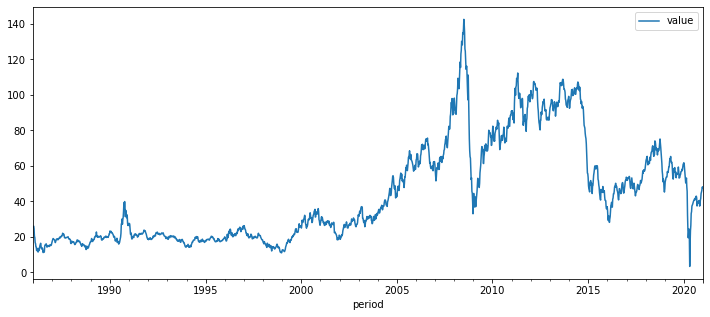

In [14]:
df.plot(figsize=(12, 5))

Từ đồ thị cho, ta dễ dàng thấy được đường biểu diễn giá trị có dạng răng cưa chi chít, chứng tỏ giá trị thay đổi rất thường xuyên về xu hướng tăng giảm. Có thể bước đầu nhận định mô hình sẽ khó có thể dự đoán đúng được kết quả.

## Phân tách các tập dữ liệu

Với câu hỏi ban đầu và bảng xây dựng được, mỗi dòng dữ liệu là 1 tuần giao dịch chứa các thuộc tính là giá trị của 3 tuần giao dịch trước đó và trạng thái tăng giảm giá trị của tuần đó so với tuần trước, ta không cần phải duy trì thứ tự thời gian của tập dữ liệu mà ta có thể lấy ngẫu nhiên các dòng dữ liệu để xây dựng các tập train, validation và test.

In [15]:
y_sr = data_df['state']
X_df = data_df.drop('state',axis=1)

In [16]:
#Chia train, validation, test theo tỉ lệ 60%:20%:20%
train_val_X_df, test_X_df, train_val_y_sr , test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, random_state=0, stratify=y_sr)
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(train_val_X_df, train_val_y_sr, test_size=0.25, random_state=0, stratify=train_val_y_sr)

In [17]:
train_X_df.shape

(1094, 3)

In [18]:
train_y_sr.shape

(1094,)

In [19]:
val_X_df.shape

(365, 3)

In [20]:
val_y_sr.shape

(365,)

In [20]:
test_X_df.shape

(365, 3)

In [21]:
test_y_sr.shape

(365,)

## Tiền xử lý

Giả thiết đặt ra là giá trị WTI sẽ luôn xoay quanh một mức trung bình tại một khoảng thời gian nhất định. Vì vậy, ta sẽ tính toán thêm một cột giá trị trung bình của 3 tuần trước đó là cột `Average_3_weeks_before` với kỳ vọng rằng giá trị này sẽ hỗ trợ cho việc mô hình hóa dữ liệu trở nên tốt hơn.

In [26]:
class Mean3WeeksColAdder(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        mean_col = X_df.mean(axis=1)
        return pd.concat([mean_col.to_frame('Average_3_weeks_before'),X_df],axis=1)

### Tiền xử lý tập huấn luyện

In [27]:
coladder = Mean3WeeksColAdder()
coladder.transform(train_X_df)

,Average_3_weeks_before,value_1_trading_week(s)_ago,value_2_trading_week(s)_ago,value_3_trading_week(s)_ago
period,,,,
1996-04-19,22.823333,23.95,22.49,22.03
2004-01-23,33.693333,34.51,33.89,32.68
2012-04-20,103.730000,102.55,103.52,105.12
2020-05-15,14.163333,23.46,15.71,3.32
1991-07-05,20.043333,20.21,20.08,19.84
...,...,...,...,...
1989-09-22,19.293333,19.80,19.31,18.77
1998-06-19,14.476667,13.42,15.02,14.99
2018-11-09,67.576667,65.06,67.43,70.24


In [31]:
coladder.transform(train_X_df).isna().sum()

Average_3_weeks_before         0
value_1_trading_week(s)_ago    0
value_2_trading_week(s)_ago    0
value_3_trading_week(s)_ago    0
dtype: int64

Việc tính toán cột trung bình không xảy ra điều gì bất thường.

### Tiền xử lý tập validation

Dữ liệu giá trị theo thời gian là một dạng dữ liệu khá đặc biệt sẽ không tồn tại các giá trị thiếu. Chẳng hạn, nếu xảy ra một sự cố nào đó một ngày không thể giao dịch thì giá trị được ghi nhận của hôm đó sẽ là giá trị của lần cuối cùng được ghi nhận. Nên việc tính toán trung bình ở tập validation hay tập test là hoàn toàn có khả năng.

In [32]:
coladder.transform(val_X_df)

,Average_3_weeks_before,value_1_trading_week(s)_ago,value_2_trading_week(s)_ago,value_3_trading_week(s)_ago
period,,,,
1987-07-03,20.156667,20.21,20.38,19.88
1990-12-28,27.223333,27.56,26.39,27.72
2019-12-06,57.273333,58.07,56.90,56.85
2013-03-15,92.523333,91.00,92.19,94.38
1994-03-04,14.480000,14.44,14.13,14.87
...,...,...,...,...
2004-07-02,37.850000,37.70,37.86,37.99
2019-02-08,52.810000,53.63,52.88,51.92
1999-03-12,12.306667,12.90,12.36,11.66


### Một số đánh giá

- Dữ liệu timeseries của chỉ số WTI này không có quá nhiều điều cần phải thực hiện khi tiền xử lý.
- Giá trị này luôn thay đổi tăng giảm theo thời gian, những ngày ghi nhận đầu là lúc kinh tế chưa phát triển giá trị sẽ thấp và hiện tại thì sẽ cao hơn. Đồng thời, chúng ta cũng đã chia tập dữ liệu một cách ngẫu nhiên ngày tháng năm không theo trình tự thời gian, do đó **giá trị của các cột dữ liệu** sẽ không có phân phối quanh một giá trị trung bình nên ở đây ta sẽ không dùng `StandardScaler`.

## Mô hình hóa

Ta sẽ sử dụng mô hình Neural Network để phân lớp. Đầu tiên, chúng ta sẽ tạo một pipeline gồm 2 bước:
- Bước 1: Tiền xử lý, tính giá trị trung bình của 3 tuần giao dịch trước.
- Bước 2: Thực hiện mô hình hóa bằng Neural Network.

Mô hình Neural Network được chọn ở đây sẽ có các siêu tham số đầu vào (`activation ='relu', solver='lgfbs', max_iter=2500, random_state = 0`).

Sau khi chọn các siêu tham số như trên, ta sẽ có một số thử nghiệm:
- Siêu tham số alpha với 5 giá trị khác nhau: 0.0001, 0.01, 1, 10, 100.
- 

In [87]:
estimator = MLPClassifier(activation='relu', solver='lbfgs', max_iter=2500, random_state=0)

In [88]:
train_errs = []
val_errs = []
layer_sizes = [10,20,50,100]
alphas = [0.0001, 0.01, 1, 10, 100]
for layer_size in layer_sizes:
    for alpha in alphas:
        estimator.set_params(hidden_layer_sizes=(layer_size),alpha=alpha)
        estimator.fit(train_X_df, train_y_sr)
        train_errs.append((1-estimator.score(train_X_df,train_y_sr))*100)
        val_errs.append((1-estimator.score(val_X_df,val_y_sr))*100)

In [89]:
train_errs

[42.413162705667276,
 42.413162705667276,
 42.413162705667276,
 42.413162705667276,
 42.321755027422306,
 42.230347349177336,
 42.413162705667276,
 42.04753199268738,
 41.59049360146252,
 41.95612431444241,
 42.04753199268738,
 41.224862888482626,
 41.95612431444241,
 41.95612431444241,
 41.95612431444241,
 41.6819012797075,
 42.59597806215722,
 40.95063985374772,
 42.413162705667276,
 42.87020109689214,
 42.413162705667276,
 42.77879341864717,
 42.59597806215722,
 42.230347349177336]

In [90]:
val_errs

[41.0958904109589,
 41.0958904109589,
 41.0958904109589,
 41.0958904109589,
 41.917808219178085,
 41.917808219178085,
 41.64383561643835,
 41.917808219178085,
 41.36986301369863,
 41.36986301369863,
 42.19178082191781,
 40.821917808219176,
 41.917808219178085,
 41.0958904109589,
 41.917808219178085,
 41.64383561643835,
 42.465753424657535,
 40.273972602739725,
 41.0958904109589,
 41.917808219178085,
 41.36986301369863,
 41.0958904109589,
 41.917808219178085,
 42.73972602739726]